In [89]:
import numpy as np
import random
import tsplib95
import matplotlib.pyplot as plt

def get_distance(node1, node2, problem):
    # Access the coordinates or other relevant data for node1 and node2
    coord1 = problem.node_coords[node1]
    coord2 = problem.node_coords[node2]

    # Calculate distance based on your specific requirements
    #  Euclidean distance calculation
    distance = np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)
    return distance

problem = tsplib95.load_problem('/Users/hanyfaltaos/Downloads/NeuoralSub/A4/tsplib95-master/archives/problems/tsp/att48.tsp',special=get_distance)



/var/folders/zr/0jj11rzn1m70682xsp91vxj00000gn/T/ipykernel_2081/2735772782.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) load_problem. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecated since version 7.0.0.
  problem = tsplib95.load_problem('/Users/hanyfaltaos/Downloads/NeuoralSub/A4/tsplib95-master/archives/problems/tsp/bays29.tsp',special=get_distance)


In [90]:
def create_tour(cities):
    return random.sample(cities, len(cities))

def initial_population(size, cities):
    return [create_tour(cities) for _ in range(size)]

def calculate_distance(tour, problem):
    return sum(problem.get_weight(tour[i], tour[i + 1]) for i in range(len(tour) - 1))

def fitness(tour, problem):
    return 1 / calculate_distance(tour, problem)



In [91]:
#The function starts by creating a tournament group by randomly selecting `tournament_size` individuals (tours) from the population.
# These individuals will compete against each other to be selected.
def tournament_selection(population, fitness_func, tournament_size):
    tournament = random.sample(population, tournament_size)
    tournament_fitness = [fitness_func(individual) for individual in tournament]
   # The individual with the highest fitness within the tournament is declared the winner. 
    winner = tournament[np.argmax(tournament_fitness)]
    return winner

#The purpose of one-point crossover is to combine the characteristics of both parents to create diverse offspring. 
#It mimics the process of genetic recombination in natural evolution.
def ordered_crossover(parent1, parent2):
    size = len(parent1)
    child = [-1] * size
    start, end = sorted(random.sample(range(size), 2))

    # Copy a segment from the first parent to the child
    child[start:end] = parent1[start:end]
    
    # Fill in the remaining positions with the cities from the second parent
    current_pos = end
    for city in parent2:
        if city not in child:
            if current_pos >= size:
                current_pos = 0
            child[current_pos] = city
            current_pos += 1

    return child



#The `swap_mutation` function  is responsible for introducing random changes 
#(mutations) to an individual tour in the genetic algorithm. 
def swap_mutation(individual, mutation_rate):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            swap_with = random.randint(0, len(individual) - 1)
            individual[i], individual[swap_with] = individual[swap_with], individual[i]
    return individual


Stationary state reached at generation 55


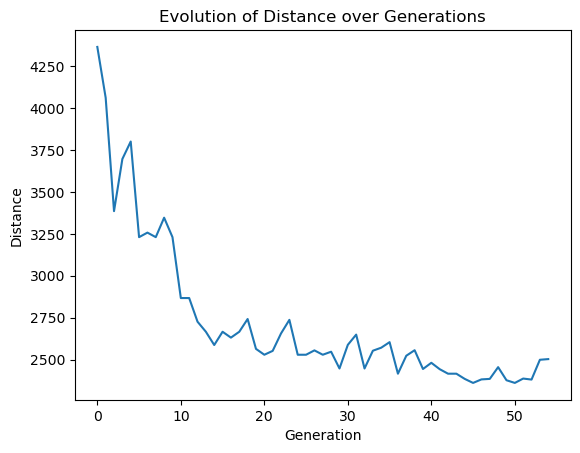

In [92]:
def genetic_algorithm(problem, generations, population_size, tournament_size, mutation_rate, elitism_size=1, stationary_limit=10):
    cities = list(problem.get_nodes())
    population = initial_population(population_size, cities)
    best_distances = []
    no_improvement_count = 0
    last_best_distance = float('inf')

    for generation in range(generations):
        new_population = []
        gen_best_distance = float('inf')
        gen_best_individual = None

        # Elitism: Carry the best individuals to the next generation
        elites = sorted(population, key=lambda tour: calculate_distance(tour, problem))[:elitism_size]
        new_population.extend(elites)

        for _ in range((len(population) - elitism_size) // 2):  # Adjust for elitism
            # Tournament selection for parents
            parent1 = tournament_selection(population, lambda tour: fitness(tour, problem), tournament_size)
            parent2 = tournament_selection(population, lambda tour: fitness(tour, problem), tournament_size)
            
            # Perform ordered crossover
            child1 = ordered_crossover(parent1, parent2)
            child2 = ordered_crossover(parent2, parent1)
            
            # Apply mutation
            child1 = swap_mutation(child1, mutation_rate)
            child2 = swap_mutation(child2, mutation_rate)
            
            new_population.extend([child1, child2])
            
            # Check if the new children are the best in this generation
            for child in [child1, child2]:
                distance = calculate_distance(child, problem)
                if distance < gen_best_distance:
                    gen_best_distance = distance
                    gen_best_individual = child

        # Detecting a stationary state
        if gen_best_distance < last_best_distance:
            last_best_distance = gen_best_distance
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= stationary_limit:
            print(f"Stationary state reached at generation {generation}")
            break

        # Replace the old population with the new population
        population = new_population
        # Store the best distance found in this generation
        best_distances.append(gen_best_distance)

    # Find the best solution at the end of the evolution
    best_solution = min(population, key=lambda tour: calculate_distance(tour, problem))
    best_solution_distance = calculate_distance(best_solution, problem)

    # Return the best solution and the list of best distances per generation
    return best_solution, best_distances, generation

# Example of running the algorithm and plotting results
best_tour, best_distances, last_generation = genetic_algorithm(problem, 100, 50, 5, 0.01)

# Plot the evolution of the best distance
plt.plot(best_distances)
plt.title('Evolution of Distance over Generations')
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.show()
